In [7]:
import numpy as np
from pathlib import Path
from src.scripts.plot_gps import load_gps_data, plot_gps_data, save_gps_fig

{(3840,
  2880): array([[1816.43929955, 1297.13622477],
        [1816.4366082 , 1297.13472106],
        [1816.44064522, 1297.14223958],
        ...,
        [1812.60413283, 1298.26249818],
        [1812.6054785 , 1298.26249818],
        [1812.6054785 , 1298.26099447]]),
 (1478,
  2217): array([[587.63929955, 950.93622477],
        [587.63660821, 950.93472106],
        [587.64064522, 950.94223958],
        ...,
        [583.80413283, 952.06249818],
        [583.8054785 , 952.06249818],
        [583.8054785 , 952.06099447]])}

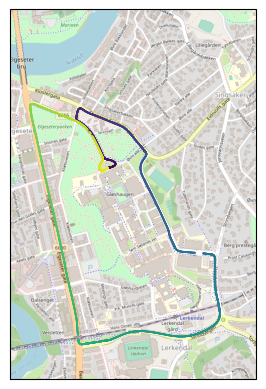

In [8]:
path = Path('/dataset/Trip019/converted/trip019_gnss50.txt')
ts, gps_coords = load_gps_data(path)
fig, world_coords, px_q = plot_gps_data(ts, gps_coords)
save_gps_fig(fig, 'fig.png')
px_q = dict(px_q)
px_q

In [9]:
from PIL import Image
image = Image.open('plan.png')
px_coords = px_q[image.size]

In [10]:
data = np.array(image)
pink = np.transpose(np.where(np.all(data == (255, 0, 255, 255), axis=-1)))

In [11]:
def find_clusters(points):
    points = set(map(tuple, points))
    clusters = []
    while points:
        point = y, x = points.pop()
        neighbors = [
            (y + i, x + j)
            for i in [-1, 0, 1]
            for j in [-1, 0, 1]
        ]
        
        matching_clusters = []
        for cluster in clusters:
            for neighbor in neighbors:
                if neighbor in cluster:
                    matching_clusters.append(cluster)
                    break
        
        if not matching_clusters:
            clusters.append({ point })
        else:
            main, *to_merge = matching_clusters
            main.add(point)
            for other in to_merge:
                main.update(other)
                other.clear()
            if to_merge:
                clusters = list(filter(None, clusters))
    
    return [np.array(list(cluster)) for cluster in clusters]

pink_clusters = find_clusters(pink)

pink_centers = []
for cluster in pink_clusters:
    y, x = np.mean(cluster, axis=0)
    pink_centers.append((x, y))

In [12]:
iplan = sorted([
    np.argmin(np.sqrt(((px_coords - wp) ** 2).sum(axis=1)))
    for wp in pink_centers
])

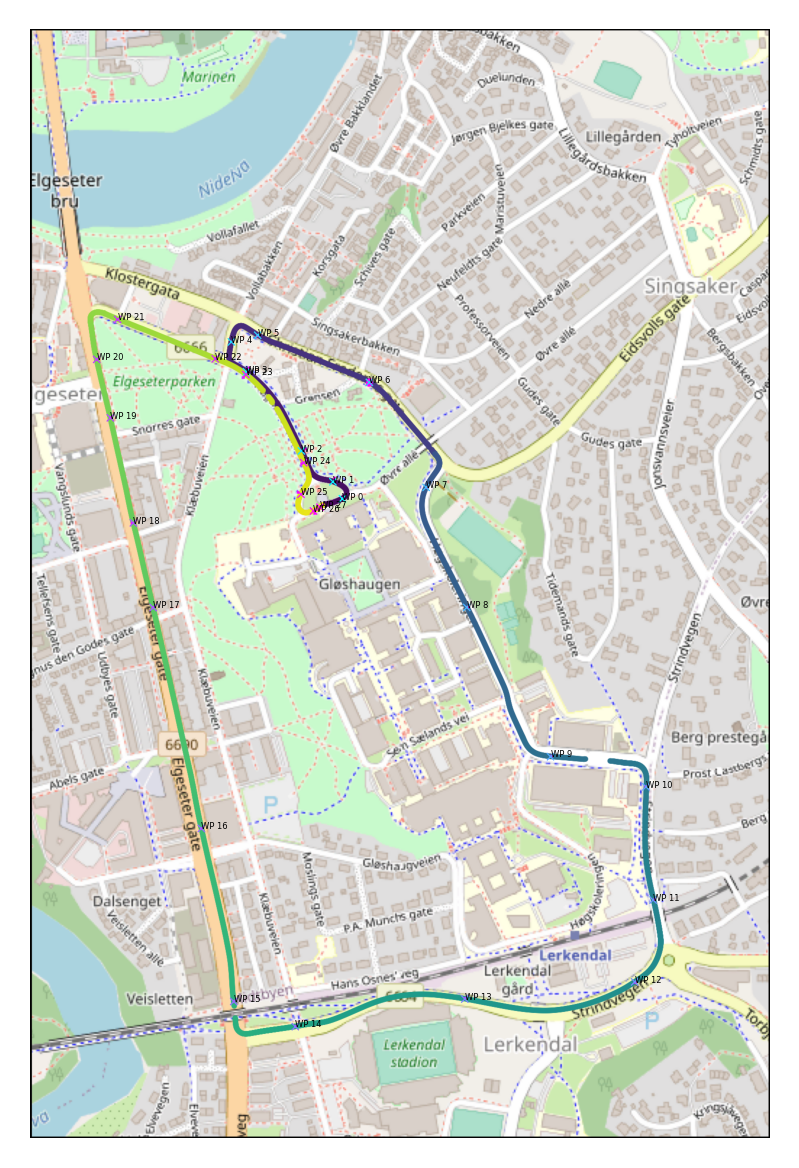

In [13]:
from matplotlib import pyplot as plt
fig = plt.figure(dpi=300)
ax = fig.add_subplot(1, 1, 1)
ax.imshow(image)
ax.set_axis_off()
ax.scatter(px_coords[iplan, 0], px_coords[iplan, 1], s=3, c=np.linspace(0, 1, len(iplan)), cmap='cool', marker='x', linewidths=0.3)
for i, idx in enumerate(iplan):
    ax.text(*px_coords[idx], f'WP {i}', fontsize=2)
fig.savefig('plan_annotated.png', dpi=600, bbox_inches='tight', pad_inches=0)

In [44]:
import pymap3d
N, E, _ = pymap3d.geodetic2ned(gps_coords[:, 0], gps_coords[:, 1], 100, *gps_coords[0], 100)

In [45]:
with open('plan.csv', 'wt') as csv:
    csv.write('idx,lat,lon,n,e\n')
    csv.writelines([
        f'{idx},{gps_coords[idx, 0]},{gps_coords[idx, 1]},{N[idx]},{E[idx]}\n'
        for idx in iplan
    ])